In [47]:
# #Read and parse data normally -- DONT RUN
# import os
# import pandas as pd
# import re


# def clean_split(data):
#     """ Cleans and properly splits a comma-separated string while preserving spaces in words like 'long-circle'. """
#     return [x.strip() for x in re.split(r",\s(?=[a-zA-Z])", data.strip(", "))] if data else []

# def parse_file(file_path):
#     with open(file_path, "r") as f:
#         content = f.read()

#     #print(f"Processing {file_path}")

#     timestamp_match = re.search(r"^([\d\-T:.Z]+), click,", content)
#     timestamp = timestamp_match.group(1) if timestamp_match else "Unknown"

#     times = re.findall(r"Times \(Movement Time\):\s*([\d., ]+) seconds", content)
#     distances = re.findall(r"Distances:\s*([\d., ]+)", content)
#     shapes = re.findall(r"Target Shapes:\s*([\w\- ,]+)", content)
#     positions = re.findall(r"\(([\d.]+)\s*,\s*([\d.]+)\)", content)
#     positions = [(float(x), float(y)) for x, y in positions] if positions else []

#     times = [float(x) for x in times[0].strip(", ").split(", ")] if times else []
#     distances = [float(x) for x in distances[0].strip(", ").split(", ")] if distances else []
#     shapes = clean_split(shapes[0]) if shapes else []

#     errors_section = re.search(r"Errors:\s*\n([\s\S]+?)\n\s*Overshoots", content)
#     errors = {}
#     if errors_section:
#         error_trials = re.findall(r"Trial (\d+):\s*([\d.]+(?:,\s*[\d.]+)*|None)", errors_section.group(1))
#         for trial, val in error_trials:
#             trial_num = int(trial)
#             errors[trial_num] = [float(x) for x in val.split(", ")] if val.lower() != "none" else []

#     overshoots_section = re.search(r"Overshoots \(correction times\):\s*\n([\s\S]+?)\n\s*Total Hover", content)
#     overshoots = {}
#     if overshoots_section:
#         overshoot_trials = re.findall(r"Trial (\d+):\s*([\d.]+(?:,\s*[\d.]+)*|None)", overshoots_section.group(1))
#         for trial, val in overshoot_trials:
#             trial_num = int(trial)
#             overshoots[trial_num] = [float(x) for x in val.split(", ")] if val.lower() != "none" else []

#     hover_times = re.findall(r"Total Hover Times \(per trial\):\s*([\d., ]+) seconds", content)
#     hover_times = [float(x) for x in hover_times[0].strip(", ").split(", ")] if hover_times else []

#     first_entry_click_delay = re.findall(r"First Entry Click Delays:\s*([\d., ]+) seconds", content)
#     first_entry_click_delay = [float(x) for x in first_entry_click_delay[0].strip(", ").split(", ")] if first_entry_click_delay else []

#     most_recent_click_delay = re.findall(r"Most Recent Entry Click Delays:\s*([\d., ]+) seconds", content)
#     most_recent_click_delay = [float(x) for x in most_recent_click_delay[0].strip(", ").split(", ")] if most_recent_click_delay else []

#     cursor_path_match = re.search(r"Cursor Path:\n([\s\S]+)", content)
#     trial_cursor_paths = []
#     current_path = []

    
#     if cursor_path_match:
#         lines = cursor_path_match.group(1).strip().split("\n")
#         prev_time = None
        
#         for line in lines:
#             parts = line.split(", ")
#             if len(parts) == 3:
#                 try:
#                     time, x, y = float(parts[0]), float(parts[1]), float(parts[2])

#                     if prev_time is not None and time < prev_time:
#                         trial_cursor_paths.append(current_path)
#                         current_path = [] 

#                     current_path.append((time, x, y))
#                     prev_time = time
#                 except ValueError:
#                     pass  
        
#         if current_path:
#             trial_cursor_paths.append(current_path)

#     while len(trial_cursor_paths) < len(times):
#         trial_cursor_paths.append([])  

#     trials = []
#     for i in range(len(times)):
#         trials.append({
#             "timestamp": timestamp,
#             "trial": i + 1,
#             "total_time": times[i] if i < len(times) else None,
#             "distance": distances[i] if i < len(distances) else None,
#             "target_shape": shapes[i] if i < len(shapes) else None,
#             "target_position": positions[i] if i < len(positions) else None,
#             "errors": errors.get(i + 1, []),
#             "overshoot_correction_times": overshoots.get(i + 1, []),
#             "hover_time": hover_times[i] if i < len(hover_times) else None,
#             "first_entry_click_delay": first_entry_click_delay[i] if i < len(first_entry_click_delay) else None,
#             "most_recent_click_delay": most_recent_click_delay[i] if i < len(most_recent_click_delay) else None,
#             "session_cursor_path": trial_cursor_paths[i] if i < len(trial_cursor_paths) else []
#         })

#     return trials

# from natsort import natsorted 

# all_trials = []

# folder_path = "data/mouse"
# for filename in natsorted(os.listdir(folder_path)): 
#     if filename.endswith(".txt"):
#         file_path = os.path.join(folder_path, filename)
#         all_trials.extend(parse_file(file_path))
# print(f"Mouse: Processed {len(all_trials)} trials from {len(os.listdir(folder_path))} files.")
# df_mouse = pd.DataFrame(all_trials)

# folder_path = "data/glove"
# all_trials = []  # Reset all_trials for glove data
# for filename in natsorted(os.listdir(folder_path)): 
#     if filename.endswith(".txt"):
#         file_path = os.path.join(folder_path, filename)
#         all_trials.extend(parse_file(file_path))
# print(f"Glove: Processed {len(all_trials)} trials from {len(os.listdir(folder_path))} files.")
# df_glove = pd.DataFrame(all_trials)


In [48]:
# Read data with path start point and end point manually inserted
import os
import pandas as pd
import re
screen_center = (720, 325)  

def parse_file(file_path):
    with open(file_path, "r") as f:
        content = f.read()

    #print(f"Processing {file_path}")

    timestamp_match = re.search(r"^([\d\-T:.Z]+), click,", content)
    timestamp = timestamp_match.group(1) if timestamp_match else "Unknown"

    times = re.findall(r"Times \(Movement Time\):\s*([\d., ]+) seconds", content)
    distances = re.findall(r"Distances:\s*([\d., ]+)", content)
    shapes = re.findall(r"Target Shapes:\s*([\w\- ,]+)", content)
    positions = re.findall(r"\(([\d.]+)\s*,\s*([\d.]+)\)", content)
    positions = [(float(x), float(y)) for x, y in positions] if positions else []

    times = [float(x) for x in times[0].strip(", ").split(", ")] if times else []
    distances = [float(x) for x in distances[0].strip(", ").split(", ")] if distances else []
    shapes = clean_split(shapes[0]) if shapes else []

    errors_section = re.search(r"Errors:\s*\n([\s\S]+?)\n\s*Overshoots", content)
    errors = {}
    if errors_section:
        error_trials = re.findall(r"Trial (\d+):\s*([\d.]+(?:,\s*[\d.]+)*|None)", errors_section.group(1))
        for trial, val in error_trials:
            trial_num = int(trial)
            errors[trial_num] = [float(x) for x in val.split(", ")] if val.lower() != "none" else []

    overshoots_section = re.search(r"Overshoots \(correction times\):\s*\n([\s\S]+?)\n\s*Total Hover", content)
    overshoots = {}
    if overshoots_section:
        overshoot_trials = re.findall(r"Trial (\d+):\s*([\d.]+(?:,\s*[\d.]+)*|None)", overshoots_section.group(1))
        for trial, val in overshoot_trials:
            trial_num = int(trial)
            overshoots[trial_num] = [float(x) for x in val.split(", ")] if val.lower() != "none" else []

    hover_times = re.findall(r"Total Hover Times \(per trial\):\s*([\d., ]+) seconds", content)
    hover_times = [float(x) for x in hover_times[0].strip(", ").split(", ")] if hover_times else []

    first_entry_click_delay = re.findall(r"First Entry Click Delays:\s*([\d., ]+) seconds", content)
    first_entry_click_delay = [float(x) for x in first_entry_click_delay[0].strip(", ").split(", ")] if first_entry_click_delay else []

    most_recent_click_delay = re.findall(r"Most Recent Entry Click Delays:\s*([\d., ]+) seconds", content)
    most_recent_click_delay = [float(x) for x in most_recent_click_delay[0].strip(", ").split(", ")] if most_recent_click_delay else []

    cursor_path_match = re.search(r"Cursor Path:\n([\s\S]+)", content)
    trial_cursor_paths = []
    current_path = []
    prev_target_position = screen_center 

    if cursor_path_match:
        lines = cursor_path_match.group(1).strip().split("\n")
        prev_time = None

        for line in lines:
            parts = line.split(", ")
            if len(parts) == 3:
                try:
                    time, x, y = float(parts[0]), float(parts[1]), float(parts[2])

                    if prev_time is not None and time < prev_time:
                        if prev_target_position:
                            current_path.append((time, *prev_target_position))
                        trial_cursor_paths.append(current_path)
                        current_path = [] 

                    current_path.append((time, x, y))
                    prev_time = time
                except ValueError:
                    pass  

        if current_path:
            current_path.append((time, *prev_target_position))  
            trial_cursor_paths.append(current_path)

    adjusted_paths = []
    for i, path in enumerate(trial_cursor_paths):
        start_point = screen_center if i == 0 else positions[i - 1] 
        end_point = positions[i] if i < len(positions) else None  

        if path:
            adjusted_path = [(0, *start_point)] + path
            if end_point:
                adjusted_path.append((path[-1][0] + 1, *end_point)) 
            adjusted_paths.append(adjusted_path)
        else:
            adjusted_paths.append([])

    while len(adjusted_paths) < len(times):
        adjusted_paths.append([])  

    trials = []
    for i in range(len(times)):
        trials.append({
            "timestamp": timestamp,
            "trial": i + 1,
            "total_time": times[i] if i < len(times) else None,
            "distance": distances[i] if i < len(distances) else None,
            "target_shape": shapes[i] if i < len(shapes) else None,
            "target_position": positions[i] if i < len(positions) else None,
            "errors": errors.get(i + 1, []),
            "overshoot_correction_times": overshoots.get(i + 1, []),
            #"hover_time": hover_times[i] if i < len(hover_times) else None,
            "hover_time": hover_times[i] + most_recent_click_delay[i] if (first_entry_click_delay[i] != most_recent_click_delay[i]) else hover_times[i],
            "first_entry_click_delay": first_entry_click_delay[i] if i < len(first_entry_click_delay) else None,
            "most_recent_click_delay": most_recent_click_delay[i] if i < len(most_recent_click_delay) else None,
            "session_cursor_path": adjusted_paths[i] if i < len(adjusted_paths) else []
        })

    return trials

def clean_split(data):
    """ Cleans and properly splits a comma-separated string while preserving spaces in words like 'long-circle'. """
    return [x.strip() for x in re.split(r",\s(?=[a-zA-Z])", data.strip(", "))] if data else []

from natsort import natsorted 

all_trials = []

folder_path = "data/mouse"
for filename in natsorted(os.listdir(folder_path)): 
    if filename.endswith(".txt"):
        file_path = os.path.join(folder_path, filename)
        all_trials.extend(parse_file(file_path))
print(f"Mouse: Processed {len(all_trials)} trials from {len(os.listdir(folder_path))} files.")
df_mouse = pd.DataFrame(all_trials)

folder_path = "data/glove"
all_trials = []  
for filename in natsorted(os.listdir(folder_path)): 
    if filename.endswith(".txt"):
        file_path = os.path.join(folder_path, filename)
        all_trials.extend(parse_file(file_path))
print(f"Glove: Processed {len(all_trials)} trials from {len(os.listdir(folder_path))} files.")
df_glove = pd.DataFrame(all_trials)

Mouse: Processed 255 trials from 51 files.
Glove: Processed 295 trials from 60 files.


In [49]:
#Calculating the other metrics/features
import numpy as np

def process_dataframe(df, screen_center):
    df["prev_target_distance"] = np.nan
    df["velocity"] = np.nan
    df["error_count"] = df["errors"].apply(len)
    df["total_overshoot_time"] = df["overshoot_correction_times"].apply(sum)
    df["actual_path_length"] = np.nan
    df["optimal_path_ratio"] = np.nan
    df["extra_movement_percentage"] = np.nan
    
    for i in range(len(df)):
        if df.loc[i, "target_position"] is not None:
            if df.loc[i, "trial"] % 5 == 0:  
                prev_x, prev_y = screen_center
            else: 
                prev_x, prev_y = df.loc[i - 1, "target_position"] if i > 0 else screen_center

            x, y = df.loc[i, "target_position"]
            df.loc[i, "prev_target_distance"] = np.sqrt((x - prev_x) ** 2 + (y - prev_y) ** 2)

            if df.loc[i, "total_time"] > 0:
                df.loc[i, "velocity"] = df.loc[i, "prev_target_distance"] / df.loc[i, "total_time"]

            if df.loc[i, "session_cursor_path"]:
                path = np.array([(x, y) for _, x, y in df.loc[i, "session_cursor_path"]])
                actual_path_length = np.sum(np.linalg.norm(np.diff(path, axis=0), axis=1))
                df.loc[i, "actual_path_length"] = actual_path_length

                if df.loc[i, "prev_target_distance"] > 0:
                    df.loc[i, "optimal_path_ratio"] = actual_path_length / df.loc[i, "prev_target_distance"]
                    df.loc[i, "extra_movement_percentage"] = (actual_path_length - df.loc[i, "prev_target_distance"]) / df.loc[i, "prev_target_distance"]
    
    cols = [col for col in df.columns if col != "session_cursor_path"] + ["session_cursor_path"]
    return df[cols]

screen_center = (720, 325)

df_mouse = process_dataframe(df_mouse, screen_center)
df_glove = process_dataframe(df_glove, screen_center)

In [50]:
# #MOUSE CALCS BUT LIKE separate -- DONT RUN
# import numpy as np

# # Assume screen center at (960, 540)
# screen_center = (720, 325)

# # Add new columns
# df_mouse["prev_target_distance"] = np.nan
# df_mouse["velocity"] = np.nan
# df_mouse["error_count"] = df_mouse["errors"].apply(len)
# df_mouse["total_overshoot_time"] = df_mouse["overshoot_correction_times"].apply(sum)
# df_mouse["actual_path_length"] = np.nan
# df_mouse["optimal_path_ratio"] = np.nan
# df_mouse["extra_movement_percentage"] = np.nan

# # Compute distances and path efficiency
# for i in range(len(df_mouse)):
#     if df_mouse.loc[i, "target_position"] is not None:
#         if df_mouse.loc[i, "trial"] % 5 == 0:  # First trial in set
#             prev_x, prev_y = screen_center
#         else:  # Use previous target position
#             prev_x, prev_y = df_mouse.loc[i - 1, "target_position"] if i > 0 else screen_center

#         # Compute Euclidean distance
#         x, y = df_mouse.loc[i, "target_position"]
#         df_mouse.loc[i, "prev_target_distance"] = np.sqrt((x - prev_x) ** 2 + (y - prev_y) ** 2)

#         # Compute velocity (distance/time)
#         if df_mouse.loc[i, "total_time"] > 0:
#             df_mouse.loc[i, "velocity"] = df_mouse.loc[i, "prev_target_distance"] / df_mouse.loc[i, "total_time"]

#         # Compute path efficiency
#         if df_mouse.loc[i, "session_cursor_path"]:
#             path = np.array([(x, y) for _, x, y in df_mouse.loc[i, "session_cursor_path"]])
#             actual_path_length = np.sum(np.linalg.norm(np.diff(path, axis=0), axis=1))
#             df_mouse.loc[i, "actual_path_length"] = actual_path_length

#             if df_mouse.loc[i, "prev_target_distance"] > 0:
#                 df_mouse.loc[i, "optimal_path_ratio"] = actual_path_length / df_mouse.loc[i, "prev_target_distance"]
#                 df_mouse.loc[i, "extra_movement_percentage"] = (actual_path_length - df_mouse.loc[i, "prev_target_distance"]) / df_mouse.loc[i, "prev_target_distance"]

# # Reorder columns
# cols = [col for col in df_mouse.columns if col != "session_cursor_path"] + ["session_cursor_path"]
# df_mouse = df_mouse[cols]

# df_mouse.head()


In [51]:
#GLOVE CALCS BUT LIKE separate -- DONT RUN
import numpy as np

# Assume screen center at (960, 540)
screen_center = (720, 325)  

# Add new columns
df_glove["prev_target_distance"] = np.nan
df_glove["velocity"] = np.nan
df_glove["error_count"] = df_glove["errors"].apply(len)
df_glove["total_overshoot_time"] = df_glove["overshoot_correction_times"].apply(sum)
df_glove["actual_path_length"] = np.nan
df_glove["optimal_path_ratio"] = np.nan
df_glove["extra_movement_percentage"] = np.nan

# Compute distances and path efficiency
for i in range(len(df_glove)):
    if df_glove.loc[i, "target_position"] is not None:
        if df_glove.loc[i, "trial"] % 5 == 0:  # First trial in set
            prev_x, prev_y = screen_center
        else:  # Use previous target position
            prev_x, prev_y = df_glove.loc[i - 1, "target_position"] if i > 0 else screen_center

        # Compute Euclidean distance
        x, y = df_glove.loc[i, "target_position"]
        df_glove.loc[i, "prev_target_distance"] = np.sqrt((x - prev_x) ** 2 + (y - prev_y) ** 2)

        # Compute velocity (distance/time)
        if df_glove.loc[i, "total_time"] > 0:
            df_glove.loc[i, "velocity"] = df_glove.loc[i, "prev_target_distance"] / df_glove.loc[i, "total_time"]

        # Compute path efficiency
        if df_glove.loc[i, "session_cursor_path"]:
            path = np.array([(x, y) for _, x, y in df_glove.loc[i, "session_cursor_path"]])
            actual_path_length = np.sum(np.linalg.norm(np.diff(path, axis=0), axis=1))
            df_glove.loc[i, "actual_path_length"] = actual_path_length

            if df_glove.loc[i, "prev_target_distance"] > 0:
                df_glove.loc[i, "optimal_path_ratio"] = actual_path_length / df_glove.loc[i, "prev_target_distance"]
                df_glove.loc[i, "extra_movement_percentage"] = (actual_path_length - df_glove.loc[i, "prev_target_distance"]) / df_glove.loc[i, "prev_target_distance"]

# Reorder columns
cols = [col for col in df_glove.columns if col != "session_cursor_path"] + ["session_cursor_path"]
df_glove = df_glove[cols]


In [52]:
df_mouse.columns, df_glove.columns

(Index(['timestamp', 'trial', 'total_time', 'distance', 'target_shape',
        'target_position', 'errors', 'overshoot_correction_times', 'hover_time',
        'first_entry_click_delay', 'most_recent_click_delay',
        'prev_target_distance', 'velocity', 'error_count',
        'total_overshoot_time', 'actual_path_length', 'optimal_path_ratio',
        'extra_movement_percentage', 'session_cursor_path'],
       dtype='object'),
 Index(['timestamp', 'trial', 'total_time', 'distance', 'target_shape',
        'target_position', 'errors', 'overshoot_correction_times', 'hover_time',
        'first_entry_click_delay', 'most_recent_click_delay',
        'prev_target_distance', 'velocity', 'error_count',
        'total_overshoot_time', 'actual_path_length', 'optimal_path_ratio',
        'extra_movement_percentage', 'session_cursor_path'],
       dtype='object'))

In [53]:
# removing high values
threshold = 15.0 

df_mouse = df_mouse[df_mouse["optimal_path_ratio"] <= threshold]
df_glove = df_glove[df_glove["optimal_path_ratio"] <= threshold]
df_glove = df_glove[df_glove["error_count"] < 10] #note this in the paper

In [54]:
df_mouse.shape, df_glove.shape

((250, 19), (292, 19))

In [55]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import ast

# def safe_eval(val):
#     if isinstance(val, str):
#         return ast.literal_eval(val)
#     return val  # If it's already a tuple, return as is

# df_mouse["target_position"] = df_mouse["target_position"].apply(safe_eval)
# df_glove["target_position"] = df_glove["target_position"].apply(safe_eval)


def compute_fitts_law(df):
    # Map target shape to width (W)
    shape_widths = {
    "circle": 1.323,  # Assuming a 50px diameter
    "square": 1.323,  # Assuming 50x50px
    "rectangle": 2.646,  # Width of 100px
    "long-rectangle": 1.323,  # Width of 50px
    "long-circle": 2.646,  # Width of 100px
}

    # Assign widths based on shape
    df["W"] = df["target_shape"].map(shape_widths)

    # Compute Index of Difficulty (ID)
    df["ID"] = np.log2((df["prev_target_distance"] / df["W"]) + 1)

    # Compute throughput (TP = ID / MT)
    df["throughput"] = df["ID"] / df["total_time"]

    # Fit Fitts' Law: MT = a + b * ID
    X = sm.add_constant(df["ID"])  # Add constant for intercept
    y = df["total_time"]
    model = sm.OLS(y, X).fit()

    return df, model

# Apply to mouse and glove dataframes
df_mouse, model_mouse = compute_fitts_law(df_mouse)
df_glove, model_glove = compute_fitts_law(df_glove)

# Print Fitts' Law parameters
print("Mouse Model:\n", model_mouse.summary())
print("Glove Model:\n", model_glove.summary())

# Compare Throughput
print("Mouse Throughput Mean:", df_mouse["throughput"].mean())
print("Glove Throughput Mean:", df_glove["throughput"].mean())

Mouse Model:
                             OLS Regression Results                            
Dep. Variable:             total_time   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     26.05
Date:                Tue, 01 Apr 2025   Prob (F-statistic):           6.62e-07
Time:                        23:45:17   Log-Likelihood:                 56.779
No. Observations:                 250   AIC:                            -109.6
Df Residuals:                     248   BIC:                            -102.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4456      0.105      

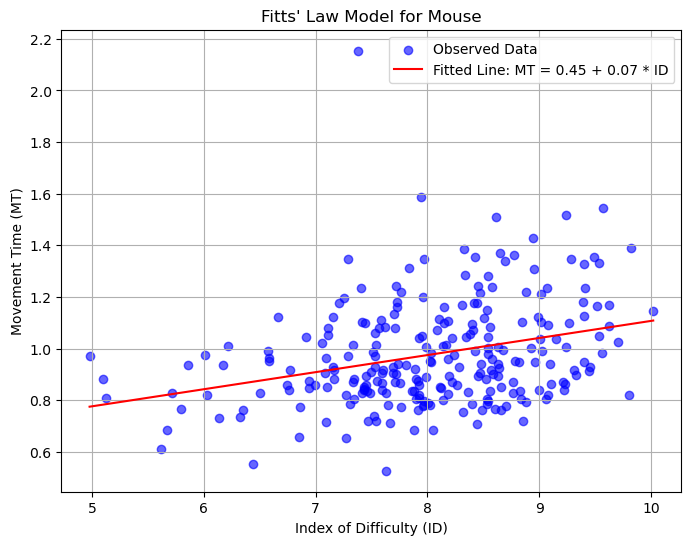

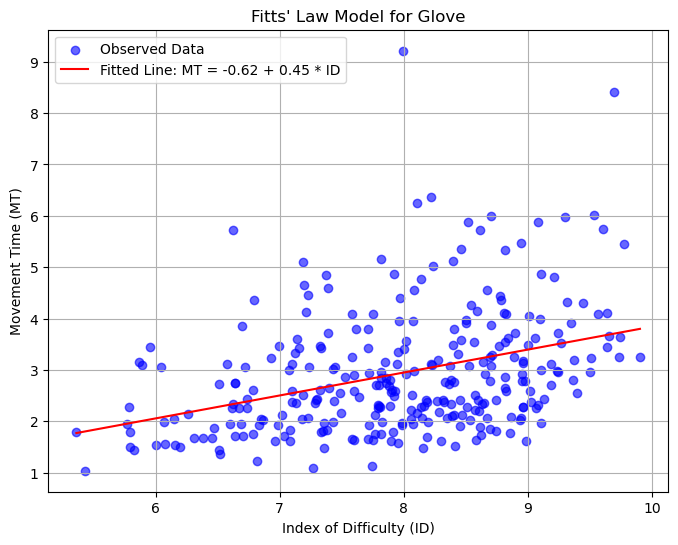

In [56]:
import matplotlib.pyplot as plt

def plot_fitts_law(df, model, device_name):
    intercept, slope = model.params

    x_vals = np.linspace(df["ID"].min(), df["ID"].max(), 100)
    y_vals = intercept + slope * x_vals

    plt.figure(figsize=(8, 6))
    plt.scatter(df["ID"], df["total_time"], alpha=0.6, label="Observed Data", color="blue")

    plt.plot(x_vals, y_vals, color="red", label=f"Fitted Line: MT = {intercept:.2f} + {slope:.2f} * ID")

    plt.title(f"Fitts' Law Model for {device_name}")
    plt.xlabel("Index of Difficulty (ID)")
    plt.ylabel("Movement Time (MT)")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_fitts_law(df_mouse, model_mouse, "Mouse")
plot_fitts_law(df_glove, model_glove, "Glove")

In [57]:
threshold = 15.0  
df_mouse = df_mouse[df_mouse["optimal_path_ratio"] <= threshold]
df_glove = df_glove[df_glove["optimal_path_ratio"] <= threshold]
df_glove = df_glove[df_glove["error_count"] < 10]



### Movement Efficiency ###

optimal_path_ratio:
  Mouse Mean: 3.7455
  Glove Mean: 3.7701
  t-statistic: -0.1330, p-value: 0.8943
----------------------------------------


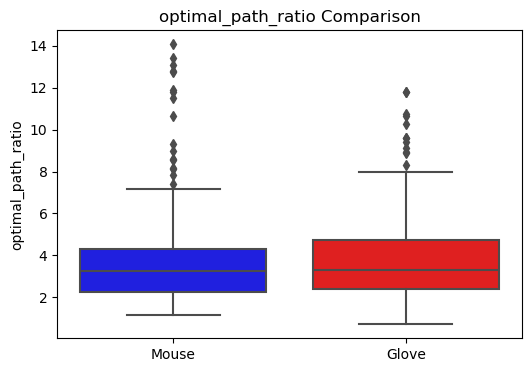


### Error Metrics ###

error_count:
  Mouse Mean: 0.0360
  Glove Mean: 0.1747
  t-statistic: -4.7006, p-value: 0.0000
----------------------------------------


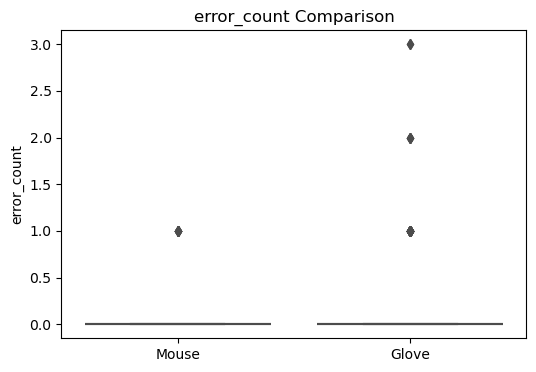

total_corrections:
  Mouse Mean: 0.1520
  Glove Mean: 0.1884
  t-statistic: -1.0351, p-value: 0.3011
----------------------------------------


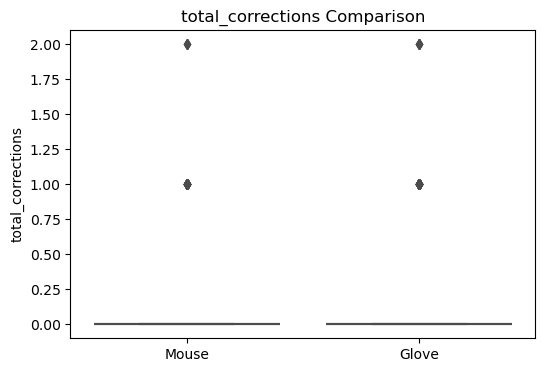


### Time-Based Error Handling ###

hover_time:
  Mouse Mean: 0.3484
  Glove Mean: 0.5096
  t-statistic: -5.4307, p-value: 0.0000
----------------------------------------


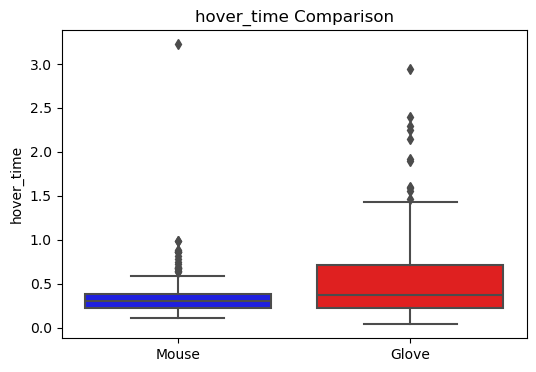

total_overshoot_time:
  Mouse Mean: 0.0377
  Glove Mean: 0.2924
  t-statistic: -5.6669, p-value: 0.0000
----------------------------------------


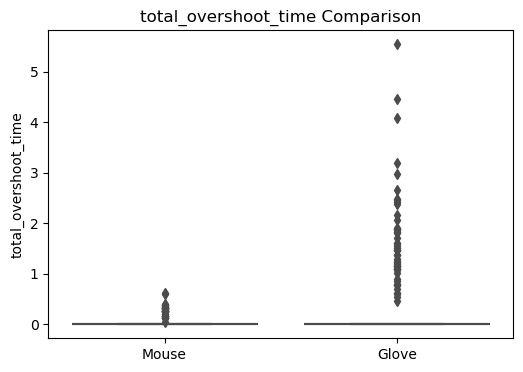

first_entry_click_delay:
  Mouse Mean: 0.3424
  Glove Mean: 0.7349
  t-statistic: -7.3324, p-value: 0.0000
----------------------------------------


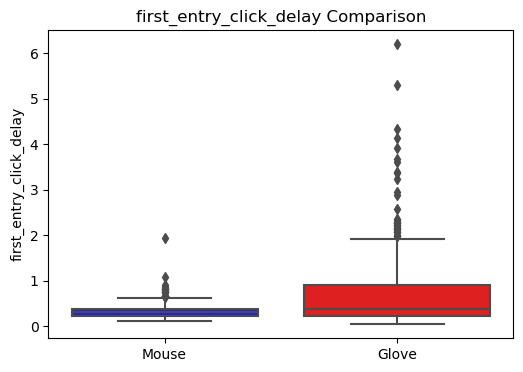

most_recent_click_delay:
  Mouse Mean: 0.2953
  Glove Mean: 0.4101
  t-statistic: -5.3591, p-value: 0.0000
----------------------------------------


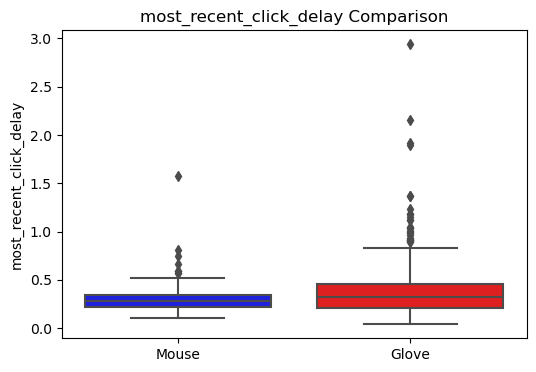

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind


df_mouse["total_corrections"] = df_mouse["overshoot_correction_times"].apply(len)
df_glove["total_corrections"] = df_glove["overshoot_correction_times"].apply(len)

movement_metrics = ["optimal_path_ratio"]
error_metrics = ["error_count", "total_corrections"]
time_based_errors = ["hover_time", "total_overshoot_time", "first_entry_click_delay", "most_recent_click_delay"]

def summarize_and_compare(df_mouse, df_glove, metrics, title):
    print(f"\n### {title} ###\n")

    for metric in metrics:
        mouse_mean = df_mouse[metric].mean()
        glove_mean = df_glove[metric].mean()
        stat, p_value = ttest_ind(df_mouse[metric], df_glove[metric], equal_var=False)  # Welch's t-test
        
        print(f"{metric}:")
        print(f"  Mouse Mean: {mouse_mean:.4f}")
        print(f"  Glove Mean: {glove_mean:.4f}")
        print(f"  t-statistic: {stat:.4f}, p-value: {p_value:.4f}")
        print("-" * 40)

        plt.figure(figsize=(6, 4))
        sns.boxplot(data=[df_mouse[metric], df_glove[metric]], palette=["blue", "red"])
        plt.xticks([0, 1], ["Mouse", "Glove"])
        plt.title(f"{metric} Comparison")
        plt.ylabel(metric)
        plt.show()

summarize_and_compare(df_mouse, df_glove, movement_metrics, "Movement Efficiency")
summarize_and_compare(df_mouse, df_glove, error_metrics, "Error Metrics")
summarize_and_compare(df_mouse, df_glove, time_based_errors, "Time-Based Error Handling")


In [59]:
# # compute total and average correction time per trial (already done above. skip)
# df_mouse["total_correction_time"] = df_mouse["overshoot_correction_times"].apply(lambda x: sum(x) if len(x) > 0 else 0)
# df_mouse["avg_correction_time"] = df_mouse["overshoot_correction_times"].apply(lambda x: np.mean(x) if len(x) > 0 else 0)

# df_glove["total_correction_time"] = df_glove["overshoot_correction_times"].apply(lambda x: sum(x) if len(x) > 0 else 0)
# df_glove["avg_correction_time"] = df_glove["overshoot_correction_times"].apply(lambda x: np.mean(x) if len(x) > 0 else 0)

# summarize_and_compare(df_mouse, df_glove, ["total_correction_time"], "Total Overshoot Correction Time")
# summarize_and_compare(df_mouse, df_glove, ["avg_correction_time"], "Average Overshoot Correction Time per Fix")


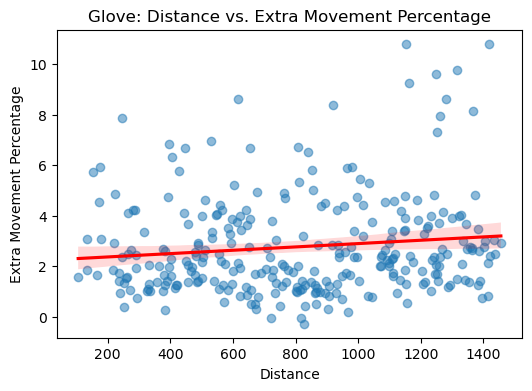

Spearman Correlation (Distance vs. Extra Movement %): 0.1129, p-value: 0.0540


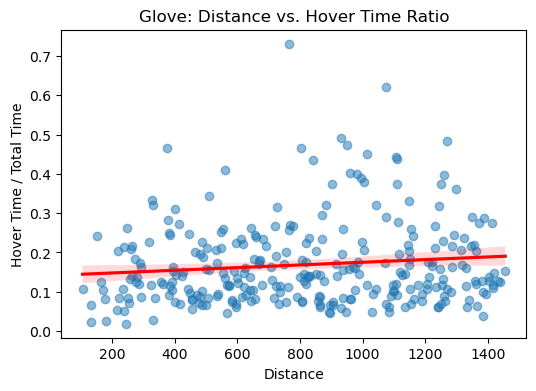

Spearman Correlation (Distance vs. Hover Time Ratio): 0.1038, p-value: 0.0766


In [60]:
#skip
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import spearmanr

plt.figure(figsize=(6, 4))
sns.regplot(x=df_glove["distance"], y=df_glove["extra_movement_percentage"], scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
plt.xlabel("Distance")
plt.ylabel("Extra Movement Percentage")
plt.title("Glove: Distance vs. Extra Movement Percentage")
plt.show()

corr_extra, p_extra = spearmanr(df_glove["distance"], df_glove["extra_movement_percentage"])
print(f"Spearman Correlation (Distance vs. Extra Movement %): {corr_extra:.4f}, p-value: {p_extra:.4f}")

df_glove["hover_ratio"] = df_glove["hover_time"] / df_glove["total_time"]

plt.figure(figsize=(6, 4))
sns.regplot(x=df_glove["distance"], y=df_glove["hover_ratio"], scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
plt.xlabel("Distance")
plt.ylabel("Hover Time / Total Time")
plt.title("Glove: Distance vs. Hover Time Ratio")
plt.show()

corr_hover, p_hover = spearmanr(df_glove["distance"], df_glove["hover_ratio"])
print(f"Spearman Correlation (Distance vs. Hover Time Ratio): {corr_hover:.4f}, p-value: {p_hover:.4f}")


In [61]:
import statsmodels.api as sm

df_glove["target_shape"] = df_glove["target_shape"].astype("category").cat.codes

predictors = ["distance", "ID", "extra_movement_percentage", "hover_time", 
              "error_count", "total_overshoot_time", "first_entry_click_delay", 
              "most_recent_click_delay", "target_shape"]
target = "total_time"

X = df_glove[predictors]
y = df_glove[target]

X = sm.add_constant(X)

model_initial = sm.OLS(y, X).fit()
print(model_initial.summary())


                            OLS Regression Results                            
Dep. Variable:             total_time   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     45.10
Date:                Tue, 01 Apr 2025   Prob (F-statistic):           1.20e-49
Time:                        23:45:19   Log-Likelihood:                -336.64
No. Observations:                 292   AIC:                             693.3
Df Residuals:                     282   BIC:                             730.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [62]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

features = ['distance', 'ID', 'extra_movement_percentage', 'hover_time',
            'error_count', 'total_overshoot_time', 'first_entry_click_delay',
            'most_recent_click_delay', 'target_shape']

df_glove['target_shape'] = pd.factorize(df_glove['target_shape'])[0]

X = df_glove[features]

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


                     Feature         VIF
0                   distance    6.492972
1                         ID   10.439750
2  extra_movement_percentage    2.678300
3                 hover_time   46.869103
4                error_count    2.015604
5       total_overshoot_time  353.399812
6    first_entry_click_delay  730.768817
7    most_recent_click_delay   85.088405
8               target_shape    3.709874


In [63]:
df_glove_reduced = df_glove.drop(columns=["first_entry_click_delay", "total_overshoot_time", "most_recent_click_delay"])

X = df_glove_reduced[["distance", "ID", "extra_movement_percentage", "hover_time", 
                      "error_count", "target_shape"]]

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


                     Feature        VIF
0                   distance   6.492159
1                         ID  10.094895
2  extra_movement_percentage   2.668219
3                 hover_time   2.535221
4                error_count   1.210188
5               target_shape   3.668015


### Actual Models

In [64]:
df_glove["target_shape"] = df_glove["target_shape"].astype("category").cat.codes

mouse_features = ['distance', 'ID', 'extra_movement_percentage', 'hover_time', 'error_count', 'target_shape']
X_glove = df_glove[mouse_features]
y_glove = df_glove['total_time']

X_glove = X_glove.dropna()
y_glove = y_glove.loc[X_glove.index]

X_glove = sm.add_constant(X_glove)
model_glove = sm.OLS(y_glove, X_glove).fit()

print(model_glove.summary())

                            OLS Regression Results                            
Dep. Variable:             total_time   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                     52.97
Date:                Tue, 01 Apr 2025   Prob (F-statistic):           1.27e-43
Time:                        23:45:19   Log-Likelihood:                -357.47
No. Observations:                 292   AIC:                             728.9
Df Residuals:                     285   BIC:                             754.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

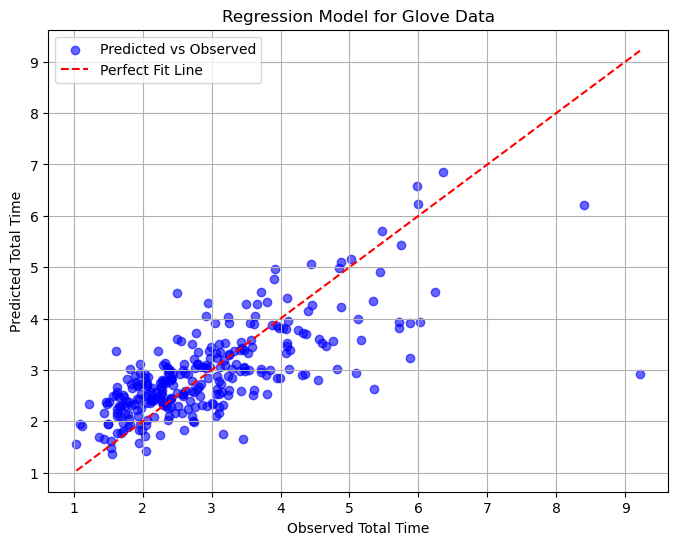

In [65]:
import matplotlib.pyplot as plt

def plot_regression_results(model, X, y, title):
    y_pred = model.predict(X)

    plt.figure(figsize=(8, 6))
    plt.scatter(y, y_pred, alpha=0.6, color="blue", label="Predicted vs Observed")
    plt.plot([y.min(), y.max()], [y.min(), y.max()], color="red", linestyle="--", label="Perfect Fit Line")

    plt.title(title)
    plt.xlabel("Observed Total Time")
    plt.ylabel("Predicted Total Time")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_regression_results(model_glove, X_glove, y_glove, "Regression Model for Glove Data")

In [66]:
df_mouse["target_shape"] = df_mouse["target_shape"].astype("category").cat.codes

mouse_features = ['distance', 'ID', 'extra_movement_percentage', 'hover_time', 'error_count', 'target_shape']
X_mouse = df_mouse[mouse_features]
y_mouse = df_mouse['total_time']

X_mouse = X_mouse.dropna()
y_mouse = y_mouse.loc[X_mouse.index]

X_mouse = sm.add_constant(X_mouse)

model_mouse = sm.OLS(y_mouse, X_mouse).fit()
print(model_mouse.summary())

                            OLS Regression Results                            
Dep. Variable:             total_time   R-squared:                       0.503
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     40.98
Date:                Tue, 01 Apr 2025   Prob (F-statistic):           2.51e-34
Time:                        23:45:20   Log-Likelihood:                 131.68
No. Observations:                 250   AIC:                            -249.4
Df Residuals:                     243   BIC:                            -224.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

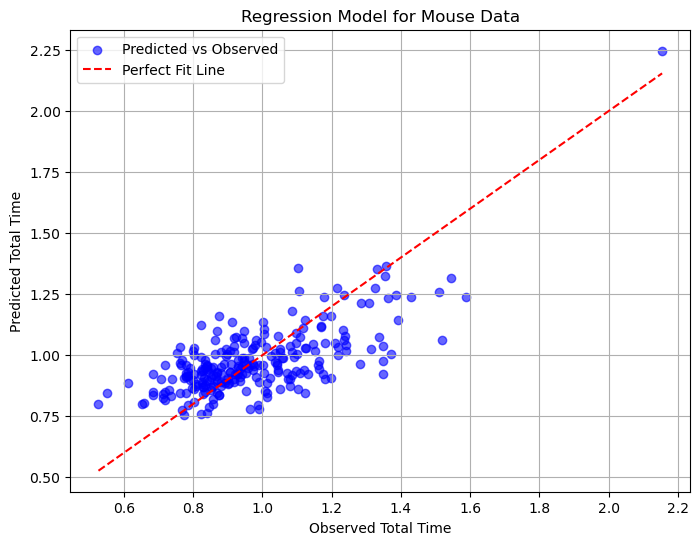

In [67]:
plot_regression_results(model_mouse, X_mouse, y_mouse, "Regression Model for Mouse Data")

                            OLS Regression Results                            
Dep. Variable:             total_time   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     212.5
Date:                Tue, 01 Apr 2025   Prob (F-statistic):          7.74e-170
Time:                        23:45:20   Log-Likelihood:                -505.69
No. Observations:                 542   AIC:                             1031.
Df Residuals:                     532   BIC:                             1074.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

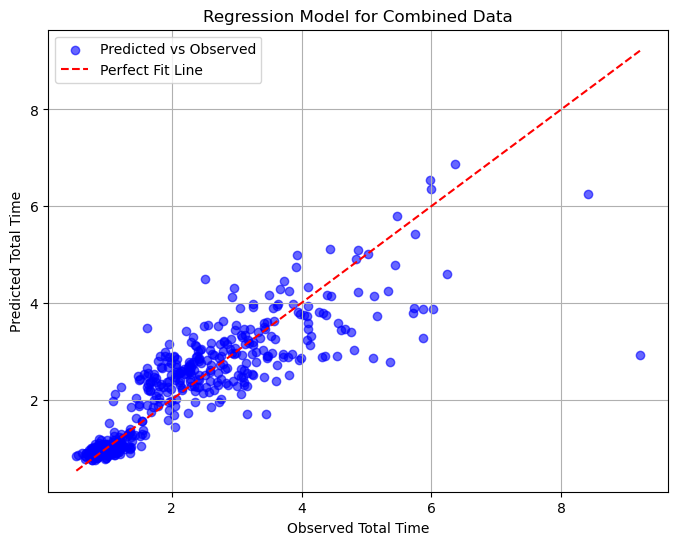

In [68]:
# Combination version
import pandas as pd
import statsmodels.api as sm

df_glove["device_type"] = 1
df_mouse["device_type"] = 0

df_combined = pd.concat([df_glove, df_mouse], ignore_index=True)

#predictors = ["distance", "ID", "extra_movement_percentage", "hover_time", "error_count", "target_shape"]
predictors = ["ID", "extra_movement_percentage", "hover_time", "error_count"]

for col in predictors:
    df_combined[f"{col}_x_device"] = df_combined[col] * df_combined["device_type"]

final_predictors = predictors + [f"{col}_x_device" for col in predictors] + ["device_type"]

X = df_combined[final_predictors]
y = df_combined["total_time"]
X = sm.add_constant(X) 

model_combined = sm.OLS(y, X).fit()
print(model_combined.summary())

plot_regression_results(model_combined, X, y, "Regression Model for Combined Data")

In [69]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Define the Poisson regression model
formula = "error_count ~ distance + ID + extra_movement_percentage + hover_time + device_type"
poisson_model = smf.poisson(formula, data=df_combined).fit()

# Print the summary
print(poisson_model.summary())


Optimization terminated successfully.
         Current function value: 0.321982
         Iterations 7
                          Poisson Regression Results                          
Dep. Variable:            error_count   No. Observations:                  542
Model:                        Poisson   Df Residuals:                      536
Method:                           MLE   Df Model:                            5
Date:                Tue, 01 Apr 2025   Pseudo R-squ.:                  0.1204
Time:                        23:45:20   Log-Likelihood:                -174.51
converged:                       True   LL-Null:                       -198.41
Covariance Type:            nonrobust   LLR p-value:                 3.913e-09
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -8.8037      1.789     -4.922      0.000     -12.

In [70]:
#print the number of rows that have an error
print(f"Mouse errors: {df_mouse['error_count'].sum()}")
print(f"Glove errors: {df_glove['error_count'].sum()}")

Mouse errors: 9
Glove errors: 51


In [71]:
formula = "error_count ~ distance + ID + extra_movement_percentage + hover_time + target_shape + total_overshoot_time + first_entry_click_delay + most_recent_click_delay"
features = ['distance', 'ID', 'extra_movement_percentage', 'hover_time', 'error_count', 'target_shape', 'total_overshoot_time', 'first_entry_click_delay', 'most_recent_click_delay']

df_mouse_cut = df_mouse[features]
poisson_model_mouse = smf.poisson(formula, data=df_mouse_cut).fit()
print(poisson_model_mouse.summary())

df_glove_cut = df_glove[features]
poisson_model_glove = smf.poisson(formula, data=df_glove_cut).fit()
print(poisson_model_glove.summary())

Optimization terminated successfully.
         Current function value: 0.135115
         Iterations 8
                          Poisson Regression Results                          
Dep. Variable:            error_count   No. Observations:                  250
Model:                        Poisson   Df Residuals:                      241
Method:                           MLE   Df Model:                            8
Date:                Tue, 01 Apr 2025   Pseudo R-squ.:                  0.1321
Time:                        23:45:20   Log-Likelihood:                -33.779
converged:                       True   LL-Null:                       -38.918
Covariance Type:            nonrobust   LLR p-value:                    0.2460
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -6.8680      5.505     -1.248      0.212     -17.

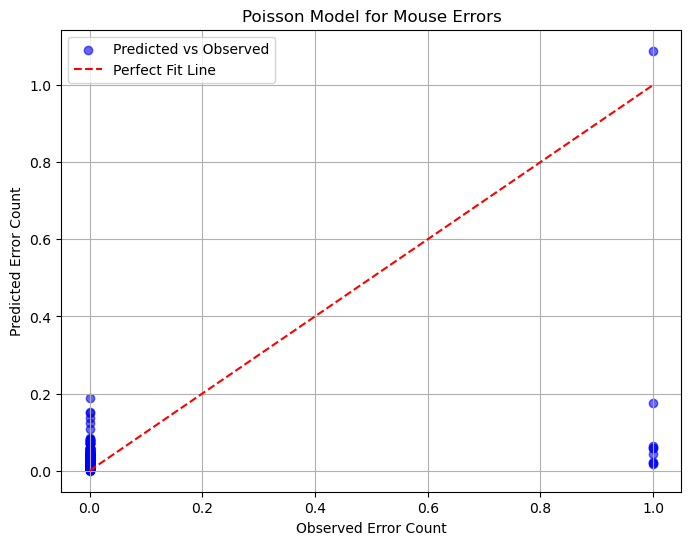

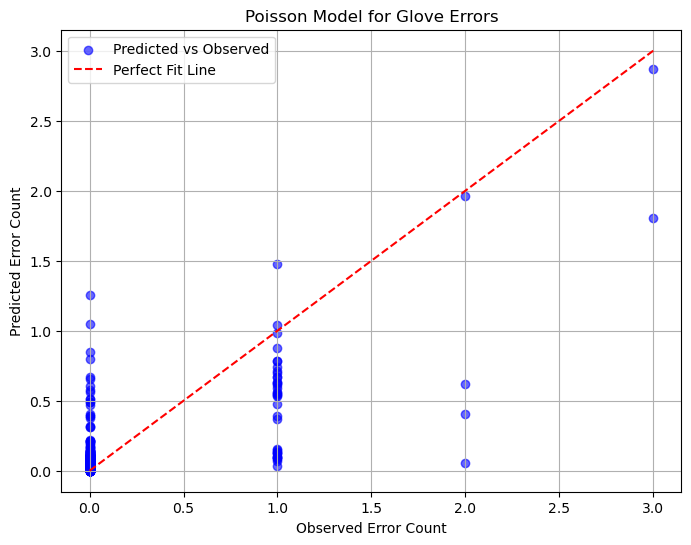

In [75]:
import matplotlib.pyplot as plt

def plot_poisson_results(model, df, features, title):
    # Get predicted values
    y_pred = model.predict(df[features])
    y_actual = df["error_count"]

    # Scatter plot of actual vs. predicted
    plt.figure(figsize=(8, 6))
    plt.scatter(y_actual, y_pred, alpha=0.6, color="blue", label="Predicted vs Observed")
    plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], color="red", linestyle="--", label="Perfect Fit Line")

    plt.title(title)
    plt.xlabel("Observed Error Count")
    plt.ylabel("Predicted Error Count")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot for both models
plot_poisson_results(poisson_model_mouse, df_mouse_cut, features, "Poisson Model for Mouse Errors")
plot_poisson_results(poisson_model_glove, df_glove_cut, features, "Poisson Model for Glove Errors")
